In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

Prior for $\theta$: Beta distribution
$$ p_{\rm prior}(\theta) = \frac{1}{B(a,b)}\theta^{a-1}(1-\theta)^{b-1}, \qquad \theta \in [0,1]$$

Likelihood of observation:
$$\mathcal{L}(\theta) = p(y|\theta) = {n \choose y} \theta^y (1-\theta)^{n-y}$$

In [3]:
a = 20 # prior: parameter a
b = 10 # prior: parameter b
n = 50 # likelihood: number of tosses
y = 10 # likelihood: number of HEADs observed. (Fixed in this example. It could be sampled form a binomial instead)
sigma = 0.1 # proposal standard deviation
theta_0 = 0.5 # a lucky guess...
N = 50_000 # chain length

* Obtain functional form of the prior, the likelihood, and of the unnormalized posterior

In [4]:
prior_fun = lambda theta: stats.beta.pdf(theta, a, b)
lik_fun = lambda theta: (theta ** y) * (1 - theta)**(n-y)

def unnorm_prior_fun(theta):
    p_theta = theta**(a-1)*(1-theta)**(b-1) # since we look for an unnormalized posterior, this is also good enough
    p_theta = p_theta * ((theta <= 1.0) & (theta >= 0.0))
    return p_theta
    
unnorm_post_fun = lambda theta: unnorm_prior_fun(theta)*lik_fun(theta)

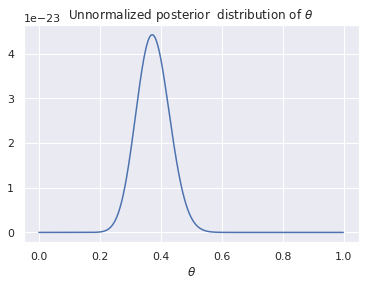

In [5]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, unnorm_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Unnormalized posterior  distribution of $\theta$");

In [6]:
# Approach 1: compute the posterior in closed-form (if you can...)

exact_post_fun = lambda theta: stats.beta.pdf(theta, a+y, b+n-y) # exact posterior

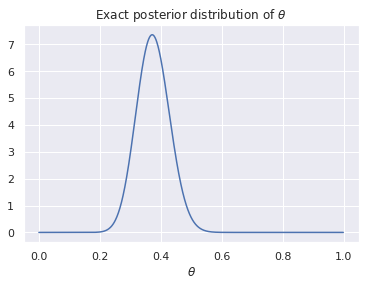

In [7]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, exact_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Exact posterior distribution of $\theta$");

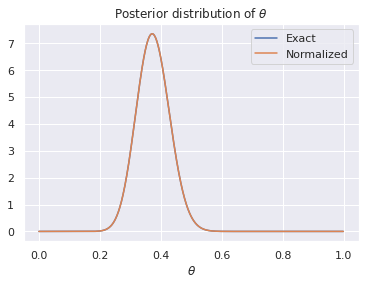

In [8]:
# Approach 2: compute normalization constant (easy in 1D, suffers curse of dimensionality...)

dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
normalization_constant = np.sum(unnorm_post_fun(theta_vec)) * dtheta
scaled_post_fun = lambda theta: unnorm_post_fun(theta)/normalization_constant

plt.plot(theta_vec, exact_post_fun(theta_vec), label="Exact")
plt.plot(theta_vec, scaled_post_fun(theta_vec), label="Normalized")
plt.xlabel(r"$\theta$");
plt.legend()
plt.title(r"Posterior distribution of $\theta$");

In [9]:
theta_step = theta_0
p_step = unnorm_post_fun(theta_step)
thetas = []

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma*np.random.randn()
    p_prop = unnorm_post_fun(theta_prop) # evaluate unscaled distribution
  
    if p_prop > p_step:
        accept = True
    else:
        p_ratio = p_prop/p_step
        accept =  np.random.binomial(1, p_ratio) # othewise, accept w.p. p_ratio
    
    if accept:
        theta_step = theta_prop
        p_step = p_prop

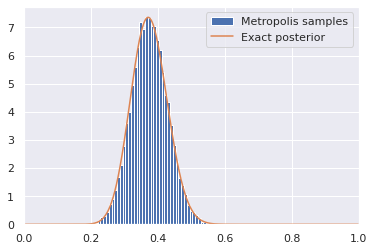

In [10]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, exact_post_fun(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);

Note: the unnormalized posterior distribution has a bad numerical scaling. In some cases, this can become an issue.

The standard approach is to work out all operations in log-domain:

\begin{align*}
\ell(\theta) &= \log \mathcal{L}(\theta) = {n \choose y} + y \log (\theta) + (n-y) \log (1-\theta) \\
 \log p_{\rm prior}(\theta) &= -\log({B(a,b)}) + (a-1) \log (\theta) + (b-1)\log(1-\theta) \\
 \log p_{\rm post}(\theta) &= \ell(\theta) + \log p_{\rm prior}(\theta) + \log p(y).
\end{align*}


In [11]:
log_lik_fun = lambda theta: y * np.log(theta) + (n-y)*np.log(1 - theta)

def unnorm_log_prior_fun(theta):
    log_p_theta = (a-1)*np.log(theta) + (b-1)*np.log(1-theta) 
    log_p_theta = log_p_theta * ((theta <= 1.0) & (theta >= 0.0))
    return log_p_theta

unnorm_log_post_fun = lambda theta: log_lik_fun(theta) + unnorm_log_prior_fun(theta)

/tmp/ipykernel_34982/2640898426.py:1: RuntimeWarning: divide by zero encountered in log
  log_lik_fun = lambda theta: y * np.log(theta) + (n-y)*np.log(1 - theta)
/tmp/ipykernel_34982/2640898426.py:4: RuntimeWarning: divide by zero encountered in log
  log_p_theta = (a-1)*np.log(theta) + (b-1)*np.log(1-theta)


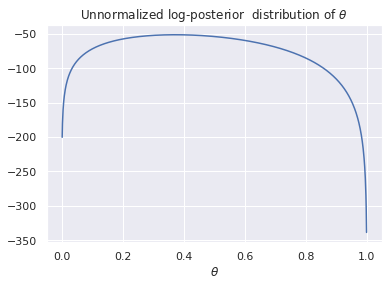

In [12]:
dtheta = 1e-3
theta_vec = np.arange(0, 1, dtheta)
plt.plot(theta_vec, unnorm_log_post_fun(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Unnormalized log-posterior  distribution of $\theta$");

The log-posterior has a much better scaling!

Then, $p_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm previous}) = \frac{p_{\rm post}(\theta_{\rm proposal})}{p_{\rm post}(\theta_{\rm previous})}$ may be computed in a more numerically stable way by exponentiating the difference between the log-posteriors at $\theta_{\rm proposal}$ and $\theta_{\rm previous}$,  exploiting the identity:


$$p_{\rm ratio}(\theta_{\rm proposal}, \theta_{\rm previous}) = e^{(\log p_{\rm post}(\theta_{\rm proposal})- \log p_{\rm post}(\theta_{\rm previous}))}$$

In [13]:
def p_ratio_fun(theta_propose, theta_previous):
    log_p_previous = unnorm_log_post_fun(theta_previous)
    log_p_propose = unnorm_log_post_fun(theta_propose)
    log_p_ratio = log_p_propose - log_p_previous # log(p_prop/p_prev) = log(p_prop) - log(p_prev)
    p_ratio = np.exp(log_p_ratio)
    #p_ratio = np.nan_to_num(p_ratio, nan=0.0)
    return p_ratio

In [14]:
theta_step = theta_0
thetas = []

for idx in range(N):
    thetas.append(theta_step)
    theta_prop = theta_step + sigma*np.random.randn()
    theta_prop = np.clip(theta_prop, 0, 1)
    
    p_ratio = p_ratio_fun(theta_prop, theta_step)
    accept_prob = np.minimum(1.0, p_ratio)
    accept = (np.random.rand() < accept_prob)
    
    if accept:
        theta_step = theta_prop
        p_step = p_prop

/tmp/ipykernel_34982/2640898426.py:1: RuntimeWarning: divide by zero encountered in log
  log_lik_fun = lambda theta: y * np.log(theta) + (n-y)*np.log(1 - theta)
/tmp/ipykernel_34982/2640898426.py:4: RuntimeWarning: divide by zero encountered in log
  log_p_theta = (a-1)*np.log(theta) + (b-1)*np.log(1-theta)


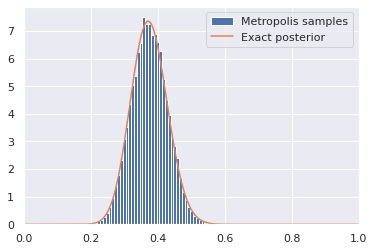

In [15]:
plt.hist(thetas, density=True, bins=50, label="Metropolis samples")
plt.plot(theta_vec, exact_post_fun(theta_vec), label="Exact posterior")
plt.legend()
plt.xlim([0, 1]);